### 1. Import Python module

In [1]:
import time
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import accuracy_score

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

num_workers = 6
categories = ['COVID19', 'NORMAL', 'PNEUMONIA']
num_classes = len(categories)
splits = ['train', 'test']
DATA_PATH = r"C:\Gunther\Datasets\Covid19DLH\Data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cuda


### 2. Data pre-processing (Augmentation + DataLoader)

In [2]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2', '']
    print(df)

def load_data(data_path=DATA_PATH, num_workers=6):
    transform_dict = {
        'model': transforms.Compose(
        [transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         ])}
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['model'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['model'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=num_workers)
    return train_loader, test_loader

train_loader, val_loader = load_data()
show_dataset()

          code train  test  total
COVID19      0   460   116    576
NORMAL       1  1266   317   1583
PNEUMONIA    2  3418   855   4273
TOTAL           5144  1288   6432


### 3. Explore processed image

[1 2 2 2 2 2 2 2 2 2 2 0 0 2 2 1 2 1 1 2 1 2 2 2 2 1 1 2 2 2 2 2]


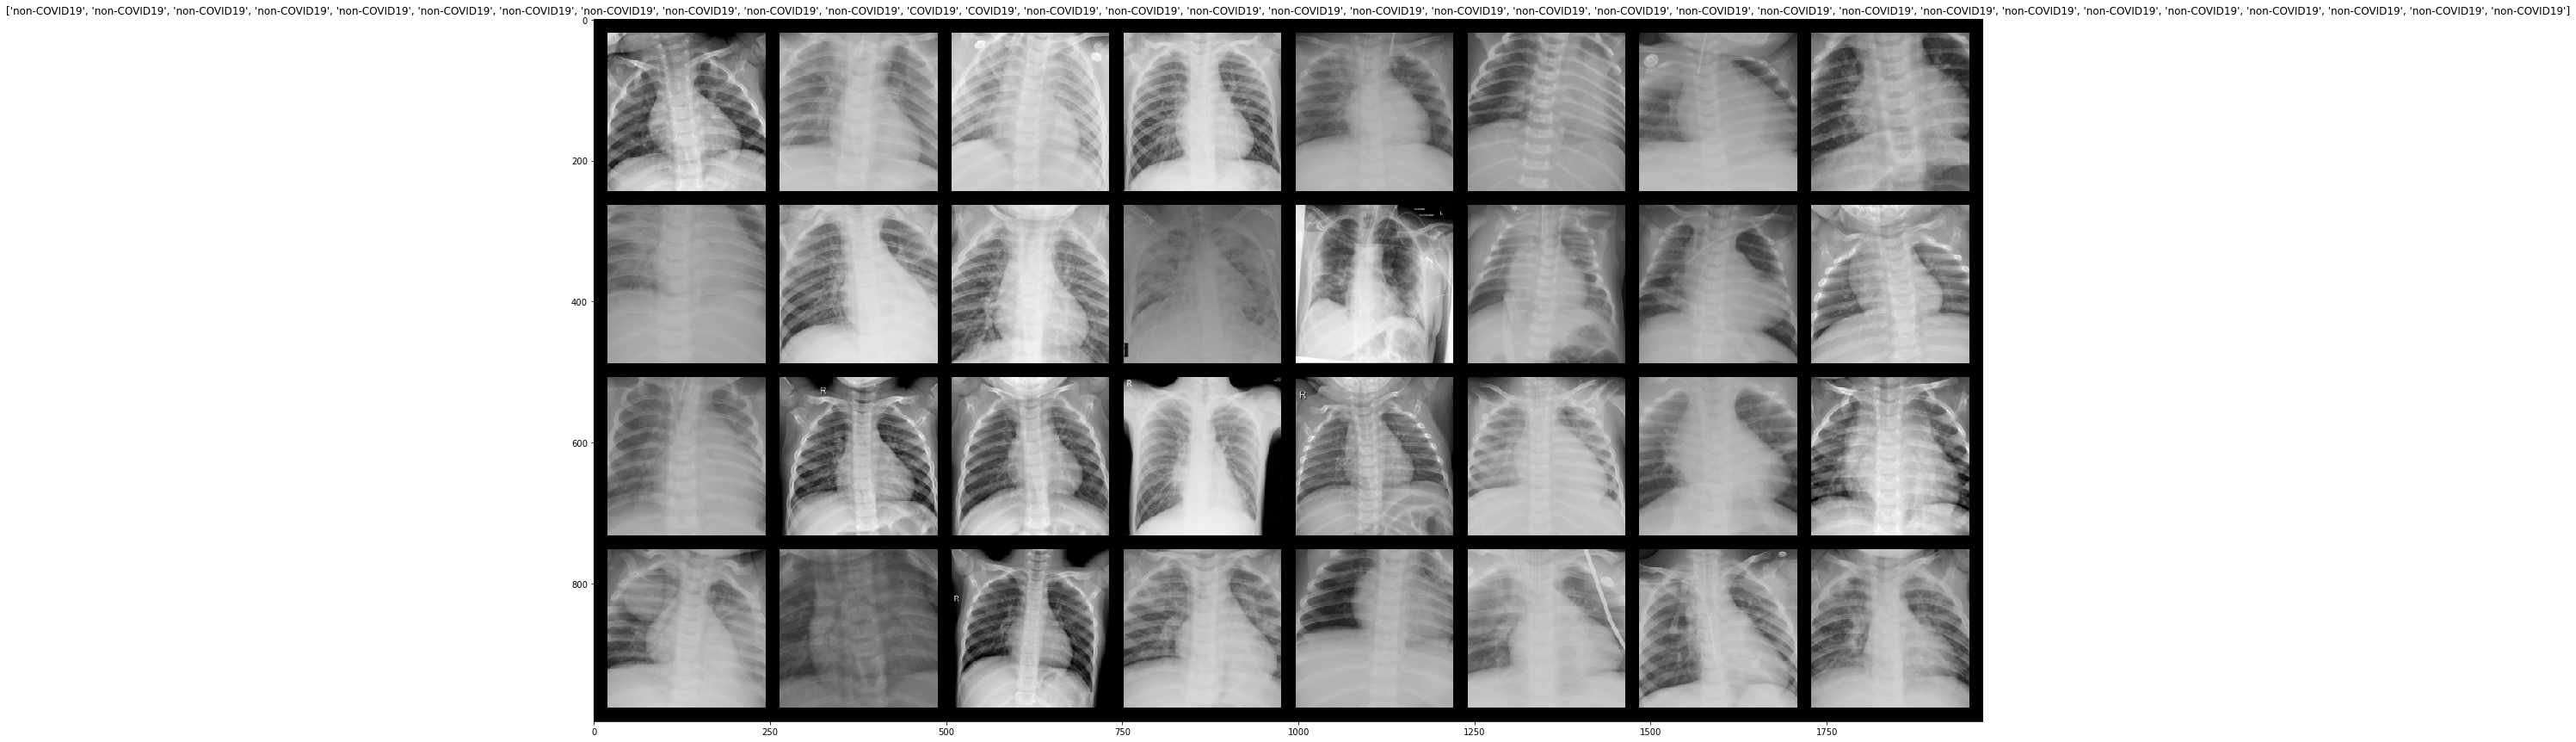

In [3]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(images, padding=20)
    npgrid = grid.cpu().numpy()
    plt.figure(figsize=(30, 15))
    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
    print(labels.numpy())
    plt.title(label=["COVID19" if x==0 else "non-COVID19" for x in labels])
    plt.show()
    
for i in range(1):
    show_batch_images(train_loader)

### 3. Create the train and evaludate functions

In [4]:
def train_model(model, train_dataloader):
    import torch.optim as optim
    model.to(device).train()
    t0 = time.time()
    print(f"Starting training model {model_name} with {n_epochs} epochs")
    for epoch in range(n_epochs):
        curr_epoch_loss = []
        for data, target in train_dataloader:
            target = target.to(device)
            data = data.to(device)
            outputs = model(data).to(device)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            curr_epoch_loss.append(loss.cpu().detach().numpy())
        print(f"Epoch {epoch}: loss={np.mean(curr_epoch_loss):.5f}  time={(time.time() - t0):.2f}s")
    return model

def evaluate_model(model, loader):
    model.eval()
    Y_pred, Y_test, predictions, actuals = [], [], [], []
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        Y_pred_orig = model(data).to(device)
        _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
        Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
        Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1)
        Y_test = target.cpu().numpy()
        Y_test = Y_test.reshape(len(Y_test), 1)
        predictions.append(Y_pred_tag)
        actuals.append(Y_test)    
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    acc = accuracy_score(Y_test, Y_pred)
    print(f"Validation Accuracy of {model_name}: {str(acc)}")
    return acc

### 4. Define pre-trained model to be retrained (model 1)

In [6]:
model_name = 'Resnet18'
n_epochs = 20
learning_rate = 1e-2

pre_trained_model = torchvision.models.resnet18(pretrained=True)
for param in pre_trained_model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = pre_trained_model.fc.in_features        
pre_trained_model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pre_trained_model.fc.parameters(), lr= learning_rate)  

#### 4.1 Retrain the model

In [ ]:
trained_model1 = train_model(pre_trained_model, train_loader)

Starting training model Resnet34 with 20 epochs
Epoch 0: loss=0.40369  time=56.63s
Epoch 1: loss=0.25181  time=112.82s
Epoch 2: loss=0.21501  time=189.59s
Epoch 3: loss=0.19983  time=241.14s
Epoch 4: loss=0.18450  time=293.33s
Epoch 5: loss=0.18413  time=344.39s
Epoch 6: loss=0.17170  time=397.52s
Epoch 7: loss=0.17434  time=448.60s
Epoch 8: loss=0.16066  time=501.18s
Epoch 9: loss=0.16373  time=552.42s


#### 4.2 Evaluate the model

In [ ]:
acc = evaluate_model(trained_model1, val_loader)

### 5. Define the architecture of the new model (model 2)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.linear1 = nn.Linear(14 * 14 * 32, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(128, 3)

    def forward(self, x):
        x = x.to(device)
        x = self.conv1(x)
        x = self.relu(self.bn1(x))
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(self.bn2(x))
        x = self.pool(x)
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

#### 5.1 Define parameters of the new model

In [6]:
model_CNN = Net()
model_name = 'Team model'
n_epochs = 20
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_CNN.parameters(), lr=learning_rate)

#### 5.2 Train the new model

In [7]:
trained_model2 = train_model(model_CNN, train_loader)

Starting training model Team model with 20 epochs
Epoch 0: loss=0.44905  time=61.19s
Epoch 1: loss=0.25295  time=122.16s
Epoch 2: loss=0.20496  time=173.54s
Epoch 3: loss=0.18809  time=226.17s
Epoch 4: loss=0.17206  time=278.38s
Epoch 5: loss=0.16197  time=330.74s
Epoch 6: loss=0.15050  time=382.43s
Epoch 7: loss=0.14164  time=434.61s
Epoch 8: loss=0.14175  time=491.68s
Epoch 9: loss=0.13264  time=547.02s
Epoch 10: loss=0.12039  time=600.98s
Epoch 11: loss=0.11916  time=654.31s
Epoch 12: loss=0.11597  time=707.66s
Epoch 13: loss=0.11334  time=761.40s
Epoch 14: loss=0.10556  time=823.34s
Epoch 15: loss=0.10917  time=874.74s
Epoch 16: loss=0.10068  time=927.38s
Epoch 17: loss=0.09703  time=979.19s
Epoch 18: loss=0.08860  time=1031.25s
Epoch 19: loss=0.08499  time=1087.16s


#### 5.3 Evaluate the new model

In [8]:
acc = evaluate_model(trained_model2, val_loader)

Validation Accuracy of Team model: 0.9510869565217391
